Importing libraries

In [168]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime,date,timedelta

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split,KFold,cross_val_score

from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

from sklearn.cluster import KMeans

import xgboost as xgb

import plotly as py
import plotly.offline as pyoff
pyoff.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import warnings
warnings.filterwarnings('ignore')

Loading the dataset

In [169]:
data=pd.read_csv('customer_segmentation.csv',encoding='cp1252')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [170]:
# pyoff.init_notebook_mode()
# data.head()

**Feature Engineering**

In [171]:
data['InvoiceDate']=pd.to_datetime(data['InvoiceDate'])

In [172]:
dt=data.dtypes
dt

,0
InvoiceNo,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,datetime64[ns]
UnitPrice,float64
CustomerID,float64
Country,object


In [173]:
data['InvoiceYearMonth']=data['InvoiceDate'].map(lambda date:100*date.year+date.month )

In [174]:
data.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID,InvoiceYearMonth
count,541909.000000,541909,541909.000000,406829.000000,541909.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570,201099.713989
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000,201012.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000,201103.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000,201107.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000,201110.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000,201112.000000
std,218.081158,NaN,96.759853,1713.600303,25.788703


In [175]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         541909 non-null  object        
 1   StockCode         541909 non-null  object        
 2   Description       540455 non-null  object        
 3   Quantity          541909 non-null  int64         
 4   InvoiceDate       541909 non-null  datetime64[ns]
 5   UnitPrice         541909 non-null  float64       
 6   CustomerID        406829 non-null  float64       
 7   Country           541909 non-null  object        
 8   InvoiceYearMonth  541909 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 37.2+ MB


In [176]:
data['Country'].value_counts()

,count
Country,
United Kingdom,495478
Germany,9495
France,8557
EIRE,8196
Spain,2533
Netherlands,2371
Belgium,2069
Switzerland,2002
Portugal,1519


In [177]:
data_UK=data.query("Country=='United Kingdom'").reset_index(drop=True)

**Segmentation**

Recency

In [178]:
user=pd.DataFrame(data['CustomerID'].unique())
user.columns=['CustomerID']
user.head()

,CustomerID
0,17850.0
1,13047.0
2,12583.0
3,13748.0
4,15100.0


In [179]:
data_UK.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012


In [180]:
max_purchase=data_UK.groupby('CustomerID').InvoiceDate.max().reset_index()
max_purchase.columns=['CustomerID','MaxPurchaseDate']

In [181]:
max_purchase.head()

,CustomerID,MaxPurchaseDate
0,12346.0,2011-01-18 10:17:00
1,12747.0,2011-12-07 14:34:00
2,12748.0,2011-12-09 12:20:00
3,12749.0,2011-12-06 09:56:00
4,12820.0,2011-12-06 15:12:00


In [182]:
#comparing the last transaction of the dataset with the transaction dates of individual customers
max_purchase['Recency']=(max_purchase['MaxPurchaseDate'].max()-max_purchase['MaxPurchaseDate']).dt.days
max_purchase.head()

,CustomerID,MaxPurchaseDate,Recency
0,12346.0,2011-01-18 10:17:00,325
1,12747.0,2011-12-07 14:34:00,1
2,12748.0,2011-12-09 12:20:00,0
3,12749.0,2011-12-06 09:56:00,3
4,12820.0,2011-12-06 15:12:00,2


In [183]:
user=pd.merge(user,max_purchase[['CustomerID','Recency']],on='CustomerID')
user.head()

,CustomerID,Recency
0,17850.0,301
1,13047.0,31
2,13748.0,95
3,15100.0,329
4,15291.0,25


Assigning a recency score

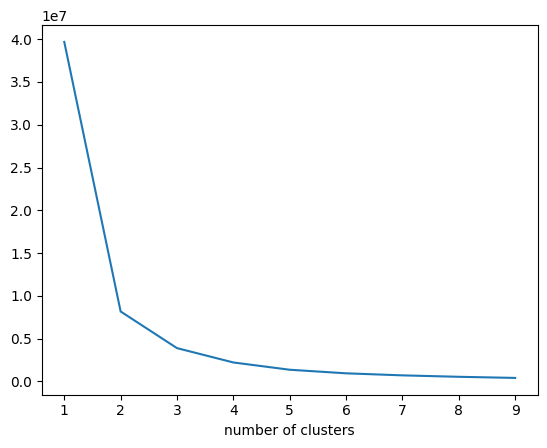

In [184]:
sse={}
recency=user[['Recency']]
for i in range(1,10):
  kmeans=KMeans(n_clusters=i,max_iter=1000).fit(recency)
  recency['clusters']=kmeans.labels_
  sse[i]=kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()),list(sse.values()))
plt.xlabel('number of clusters')
plt.show()

In [185]:
kmeans=KMeans(n_clusters=4)
user['RecencyCluster']=kmeans.fit_predict(user[['Recency']])

In [186]:
user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,954.0,77.679245,22.850898,48.0,59.00,72.5,93.00,131.0
1,478.0,304.393305,41.183489,245.0,266.25,300.0,336.00,373.0
2,1950.0,17.488205,13.237058,0.0,6.00,16.0,28.00,47.0
3,568.0,184.625000,31.753602,132.0,156.75,184.0,211.25,244.0


In [187]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final
user=order_cluster('RecencyCluster','Recency',user,False)

In [188]:
user.head()

,CustomerID,Recency,RecencyCluster
0,17850.0,301,0
1,15100.0,329,0
2,18074.0,373,0
3,16250.0,260,0
4,13747.0,373,0


In [ ]:
user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,478.0,304.393305,41.183489,245.0,266.25,300.0,336.00,373.0
1,568.0,184.625000,31.753602,132.0,156.75,184.0,211.25,244.0
2,954.0,77.679245,22.850898,48.0,59.00,72.5,93.00,131.0
3,1950.0,17.488205,13.237058,0.0,6.00,16.0,28.00,47.0


Frequency

In [192]:
frequency=data_UK.groupby('CustomerID').InvoiceDate.count().reset_index()
frequency.columns=['CustomerID','Frequency']

In [191]:
frequency.head()

,CustomerID,Frequency
0,12346.0,2
1,12747.0,103
2,12748.0,4642
3,12749.0,231
4,12820.0,59


In [190]:
user=pd.merge(user,frequency,on='CustomerID')
user.head()

,CustomerID,Recency,RecencyCluster,Frequency
0,17850.0,301,0,312
1,15100.0,329,0,6
2,18074.0,373,0,13
3,16250.0,260,0,24
4,13747.0,373,0,1


Frquency clusters

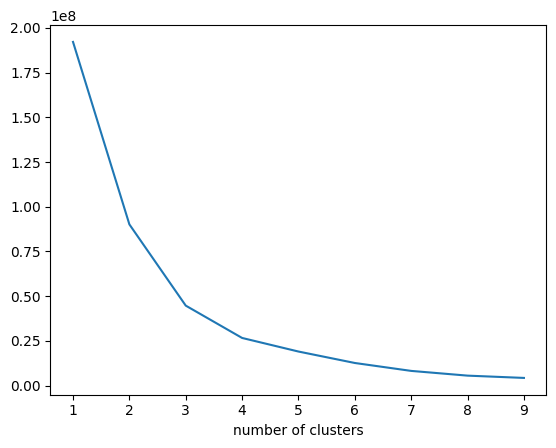

In [193]:
sse={}
recency=user[['Frequency']]
for i in range(1,10):
  kmeans=KMeans(n_clusters=i,max_iter=1000).fit(recency)
  recency["clusters"]=kmeans.labels_
  sse[i]=kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()),list(sse.values()))
plt.xlabel('number of clusters')
plt.show()

In [194]:
kmeans=KMeans(n_clusters=4)
user['FrequencyCluster']=kmeans.fit_predict(user[['Frequency']])
user=order_cluster('FrequencyCluster','Frequency',user,True)
user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3496.0,49.525744,44.954212,1.0,15.0,33.0,73.0,190.0
1,429.0,331.221445,133.856510,191.0,228.0,287.0,399.0,803.0
2,22.0,1313.136364,505.934524,872.0,988.5,1140.0,1452.0,2782.0
3,3.0,5917.666667,1805.062418,4642.0,4885.0,5128.0,6555.5,7983.0


Revenue

In [197]:
data_UK['Revenue']=data_UK['UnitPrice']*data_UK['Quantity']
revenue=data_UK.groupby('CustomerID').Revenue.sum().reset_index()

In [198]:
revenue.head()

,CustomerID,Revenue
0,12346.0,0.00
1,12747.0,4196.01
2,12748.0,29072.10
3,12749.0,3868.20
4,12820.0,942.34


In [196]:
user=pd.merge(user,revenue,on='CustomerID')
user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,17850.0,301,0,312,1,5288.63
1,15808.0,305,0,210,1,3724.77
2,13047.0,31,3,196,1,3079.10
3,14688.0,7,3,359,1,5107.38
4,16029.0,38,3,274,1,50992.61


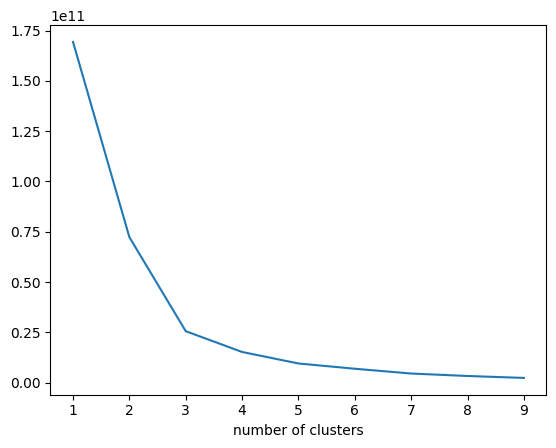

In [199]:
sse={}
recency=user[['Revenue']]
for i in range(1,10):
  kmeans=KMeans(n_clusters=i,max_iter=1000).fit(recency)
  recency['clusters']=kmeans.labels_
  sse[i]=kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()),list(sse.values()))
plt.xlabel('number of clusters')
plt.show()

revenue clusters

In [200]:
kmeans=KMeans(n_clusters=4)
user['RevenueCluster']=kmeans.fit_predict(user[['Revenue']])
user=order_cluster('RevenueCluster','Revenue',user,True)
user.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,3687.0,907.254414,921.910820,-4287.63,263.115,572.56,1258.220,4314.72
1,234.0,7760.699530,3637.173671,4330.67,5161.485,6549.38,9142.305,21535.90
2,27.0,43070.445185,15939.249588,25748.35,28865.490,36351.42,53489.790,88125.38
3,2.0,221960.330000,48759.481478,187482.17,204721.250,221960.33,239199.410,256438.49


#overall score of RFM

In [201]:
user['OverallScore']=user['RecencyCluster']+user['FrequencyCluster']+user['RevenueCluster']
user.groupby('OverallScore')[['Recency', 'Frequency', 'Revenue']].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,304.584388,21.995781,303.339705
1,185.362989,32.596085,498.087546
2,78.991304,46.963043,868.082991
3,20.689610,68.419590,1091.416414
4,14.892617,271.755034,3607.097114
5,9.662162,373.290541,9136.946014
6,7.740741,876.037037,22777.914815
7,1.857143,1272.714286,103954.025714
8,1.333333,5917.666667,42177.930000


In [ ]:
user['Segment']='Low-Value'
user.loc[user['OverallScore']>2,'Segment']='Mid-Value'
user.loc[user['OverallScore']>4,'Segment']='High-Value'

In [ ]:
user

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,17850.0,301,0,312,1,5288.63,1,2,Mid-Value
1,14688.0,7,3,359,1,5107.38,1,5,High-Value
2,13767.0,1,3,399,1,16945.71,1,5,High-Value
3,15513.0,30,3,314,1,14520.08,1,5,High-Value
4,14849.0,21,3,392,1,7904.28,1,5,High-Value
...,...,...,...,...,...,...,...,...,...
3945,12748.0,0,3,4642,3,29072.10,2,8,High-Value
3946,17841.0,1,3,7983,3,40340.78,2,8,High-Value
3947,14096.0,3,3,5128,3,57120.91,2,8,High-Value
3948,17450.0,7,3,351,1,187482.17,3,7,High-Value


Customer Lifetime Value

In [ ]:
data_UK.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34


In [ ]:
data_UK['InvoiceDate']=pd.to_datetime(data_UK['InvoiceDate'])

In [ ]:
data_UK.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34


In [ ]:
data_UK['InvoiceDate'].describe()

,InvoiceDate
count,495478
mean,2011-07-04 05:01:41.098131456
min,2010-12-01 08:26:00
25%,2011-03-27 12:06:00
50%,2011-07-19 11:47:00
75%,2011-10-20 10:41:00
max,2011-12-09 12:49:00


In [ ]:
m3 = data_UK[(data_UK.InvoiceDate < datetime(2011,6,1)) & (data_UK.InvoiceDate >= datetime(2011,3,1))].reset_index(drop=True)
m6 =data_UK[(data_UK.InvoiceDate >= datetime(2011,6,1)) & (data_UK.InvoiceDate < datetime(2011,12,1))].reset_index(drop=True)

In [ ]:
m3.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue
0,545220,21955,DOORMAT UNION JACK GUNS AND ROSES,2,2011-03-01 08:30:00,7.95,14620.0,United Kingdom,201103,15.90
1,545220,48194,DOORMAT HEARTS,2,2011-03-01 08:30:00,7.95,14620.0,United Kingdom,201103,15.90
2,545220,22556,PLASTERS IN TIN CIRCUS PARADE,12,2011-03-01 08:30:00,1.65,14620.0,United Kingdom,201103,19.80
3,545220,22139,RETROSPOT TEA SET CERAMIC 11 PC,3,2011-03-01 08:30:00,4.95,14620.0,United Kingdom,201103,14.85
4,545220,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,4,2011-03-01 08:30:00,3.75,14620.0,United Kingdom,201103,15.00


In [ ]:
m6.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue
0,555156,23299,FOOD COVER WITH BEADS SET 2,6,2011-06-01 07:37:00,3.75,15643.0,United Kingdom,201106,22.50
1,555156,22847,BREAD BIN DINER STYLE IVORY,1,2011-06-01 07:37:00,16.95,15643.0,United Kingdom,201106,16.95
2,555157,23075,PARLOUR CERAMIC WALL HOOK,16,2011-06-01 07:38:00,4.15,15643.0,United Kingdom,201106,66.40
3,555157,47590B,PINK HAPPY BIRTHDAY BUNTING,6,2011-06-01 07:38:00,5.45,15643.0,United Kingdom,201106,32.70
4,555157,22423,REGENCY CAKESTAND 3 TIER,4,2011-06-01 07:38:00,12.75,15643.0,United Kingdom,201106,51.00


In [ ]:
m6['Revenue']=m6['UnitPrice']*m6['Quantity']
data_user_6m=m6.groupby('CustomerID')['Revenue'].sum().reset_index()
data_user_6m.columns=['CustomerID','m6_Revenue']

In [ ]:
df_merge=pd.merge(user,data_user_6m,on='CustomerID',how='left')
df_merge=df_merge.fillna(0)

In [ ]:
df_merge.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue
0,17850.0,301,0,312,1,5288.63,1,2,Low-Value,0.00
1,14688.0,7,3,359,1,5107.38,1,5,High-Value,1702.06
2,13767.0,1,3,399,1,16945.71,1,5,High-Value,8910.04
3,15513.0,30,3,314,1,14520.08,1,5,High-Value,8603.26
4,14849.0,21,3,392,1,7904.28,1,5,High-Value,5498.07


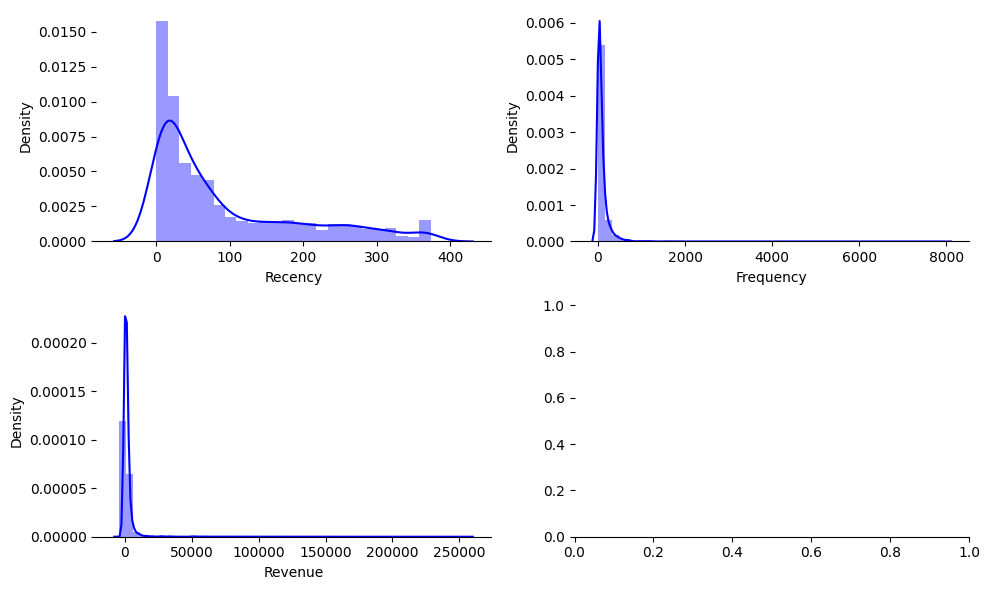

In [202]:
f,axes=plt.subplots(2,2,figsize=(10,6))
sns.despine(left=True)
sns.distplot(user.Recency,color='b',ax=axes[0,0])
sns.distplot(user.Frequency,color='b',ax=axes[0,1])
sns.distplot(user.Revenue,color='b',ax=axes[1,0])
plt.tight_layout()

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [ ]:
df_merge['Segment'] = df_merge['Segment'].astype('category').cat.codes
corr = df_merge.corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm')


,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue,LTVCluster
CustomerID,1.000000,0.014122,-0.003897,0.009918,0.023392,-0.031595,-0.015081,0.000100,0.013469,-0.026113,-0.030020
Recency,0.014122,1.000000,-0.959923,-0.304845,-0.242996,-0.311957,-0.173374,-0.892441,-0.531394,-0.408373,-0.350378
RecencyCluster,-0.003897,-0.959923,1.000000,0.313253,0.253640,0.316455,0.180754,0.929856,0.622869,0.412902,0.358319
Frequency,0.009918,-0.304845,0.313253,1.000000,0.813200,0.618260,0.491743,0.561215,-0.080293,0.592326,0.569399
FrequencyCluster,0.023392,-0.242996,0.253640,0.813200,1.000000,0.546826,0.469783,0.556251,-0.111775,0.527944,0.515867
Revenue,-0.031595,-0.311957,0.316455,0.618260,0.546826,1.000000,0.787172,0.548353,-0.121096,0.888804,0.775550
RevenueCluster,-0.015081,-0.173374,0.180754,0.491743,0.469783,0.787172,1.000000,0.454264,-0.330701,0.716779,0.605137
OverallScore,0.000100,-0.892441,0.929856,0.561215,0.556251,0.548353,0.454264,1.000000,0.428402,0.610790,0.541981
Segment,0.013469,-0.531394,0.622869,-0.080293,-0.111775,-0.121096,-0.330701,0.428402,1.000000,-0.036900,-0.000232
m6_Revenue,-0.026113,-0.408373,0.412902,0.592326,0.527944,0.888804,0.716779,0.610790,-0.036900,1.000000,0.877872


In [ ]:
print(data_user_6m.head())

   CustomerID  m6_Revenue
0     12747.0     1666.11
1     12748.0    18679.01
2     12749.0     2323.04
3     12820.0      561.53
4     12822.0      918.98


In [ ]:
user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,17850.0,301,0,312,1,5288.63,1,2,Mid-Value
1,14688.0,7,3,359,1,5107.38,1,5,High-Value
2,13767.0,1,3,399,1,16945.71,1,5,High-Value
3,15513.0,30,3,314,1,14520.08,1,5,High-Value
4,14849.0,21,3,392,1,7904.28,1,5,High-Value


In [ ]:
data_UK.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34


**Removing the Outliers**

In [ ]:
df_merge=df_merge[df_merge['m6_Revenue']<df_merge['m6_Revenue'].quantile(0.99)]

In [ ]:
kmeans=KMeans(n_clusters=3)
df_merge['LTVCluster']=kmeans.fit_predict(df_merge[['m6_Revenue']])
df_merge.head()
df_merge= order_cluster('LTVCluster', 'm6_Revenue',df_merge,True)
cluster_data = df_merge.copy()
cluster_data.groupby('LTVCluster')['m6_Revenue'].describe()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,2960.0,277.296717,282.043305,-4287.63,0.0000,229.110,452.9325,940.83
1,794.0,1609.586914,549.435635,941.95,1148.8350,1482.900,1945.7975,3113.70
2,156.0,4645.661795,1345.674897,3129.27,3537.7325,4256.115,5497.9800,8432.68


In [ ]:
cluster_data.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue,LTVCluster
0,17850.0,301,0,312,1,5288.63,1,2,Low-Value,0.0,0
1,13093.0,266,0,170,0,7741.47,1,1,Low-Value,0.0,0
2,15032.0,255,0,55,0,4464.10,1,1,Low-Value,0.0,0
3,16000.0,2,3,9,0,12393.70,1,4,Mid-Value,0.0,0
4,15749.0,234,1,15,0,21535.90,1,2,Low-Value,0.0,0


Splitting the data

In [ ]:
DF_class = pd.get_dummies(cluster_data)
corr_matrix = DF_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)
X = DF_class.drop(['LTVCluster','m6_Revenue'],axis=1)
y = DF_class['LTVCluster']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

In [ ]:
corr_matrix['LTVCluster'].sort_values(ascending=False)

,LTVCluster
LTVCluster,1.000000
m6_Revenue,0.877872
Revenue,0.775550
RevenueCluster,0.605137
Frequency,0.569399
OverallScore,0.541981
FrequencyCluster,0.515867
Segment_High-Value,0.496747
RecencyCluster,0.358319
Segment_Mid-Value,0.189268


Training the Machine Learning model

In [ ]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
xgb_clf=XGBClassifier()
logreg=LogisticRegressionCV()
knn=KNeighborsClassifier()
svc=SVC()
adb=AdaBoostClassifier()
dt_clf=DecisionTreeClassifier()
rf_clf=RandomForestClassifier()

In [ ]:
seed=42
models=[]
models.append(('LR',LogisticRegressionCV(solver='lbfgs',max_iter=5000,cv=5,multi_class='auto')))
models.append(('XGB',XGBClassifier()))
models.append(('KNN',KNeighborsClassifier(5)))
models.append(('DT',DecisionTreeClassifier(max_depth=5)))
models.append(('RF',RandomForestClassifier(n_estimators=100)))
models.append(('ADA',AdaBoostClassifier()))
models.append(('SVC',SVC(gamma='scale')))
results=[]
names=[]
scoring='accuracy'
for name,model in models:
  kfold=KFold(n_splits=10,random_state=seed,shuffle=True)
  cv_results=cross_val_score(model,X_train,y_train,cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg="%s: %f (%f)" % (name,cv_results.mean(),cv_results.std())
  print(msg)


LR: 0.888267 (0.013628)
XGB: 0.886645 (0.012773)
KNN: 0.873193 (0.013390)
DT: 0.891770 (0.012929)
RF: 0.886647 (0.015561)
ADA: 0.797008 (0.075606)
SVC: 0.879927 (0.014345)


In [ ]:
import xgboost as xgb
xgb_model=xgb.XGBClassifier(max_depth=5,learning_rate=0.1,objective='multi:softprob',n_jobs=-1).fit(X_train,y_train)
print('Accuracy of XGB classifier on training set:{:.2f}'.format(xgb_model.score(X_train,y_train)))
print('Accuracy of XGB classifier on training set:{:.2f}'.format(xgb_model.score(X_test[X_train.columns],y_test)))
y_pred=xgb_model.predict(X_test)
print(classification_report(y_test,y_pred))

Accuracy of XGB classifier on training set:0.95
Accuracy of XGB classifier on training set:0.91
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       143
           1       0.85      0.76      0.80        46
           2       0.83      0.71      0.77         7

    accuracy                           0.91       196
   macro avg       0.87      0.82      0.84       196
weighted avg       0.91      0.91      0.91       196

